# Exercise 2: Convolution GAN for MNIST digits

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda


## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [2]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4591975.19it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134938.26it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1290256.58it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2962757.20it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



QUESTION: Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


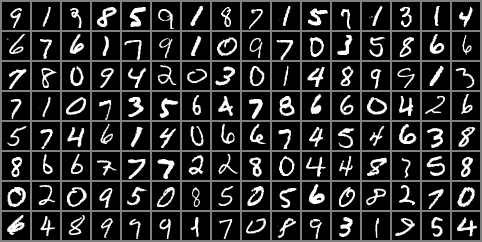

In [4]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

In [5]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


## Display Samples of the Generator

In [6]:


# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

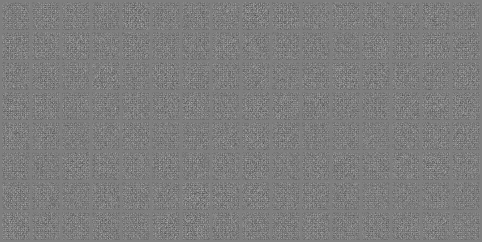

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

# Part 1: DCGAN Training with WGAN-GP loss

<br/><br/>
**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

In [8]:
def lipconstant(D,x,y):
    b = x.shape[1]
    n = y.shape[1]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)


def gradient_penalty(D,x,y):
    b = x.shape[1]
    n = y.shape[1]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2,dim=1)+1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()


y = next(iter(train_loader))[0].to(device)
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()

print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.1725, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7347, device='cuda:0', grad_fn=<MeanBackward0>)


In [9]:
def Loss_WGAN(D_y,D_g_y) :
  return D_y.mean(axis=0) - D_g_y.mean(axis=0)
def Loss_WGAN_GP (D_y,D_g_y,GP,lamda):
  return Loss_WGAN(D_y,D_g_y)-lamda*GP

[1/5][0/468][0.7283 s]	Loss_D: -0.2118	Loss_G: 0.1106	Lip(D): 0.1963


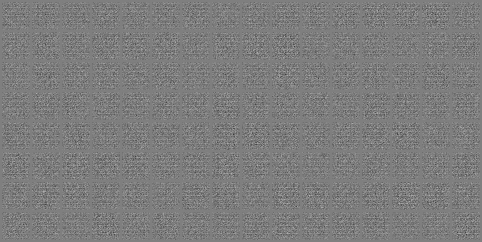

[1/5][100/468][13.0284 s]	Loss_D: -14.1957	Loss_G: 11.9227	Lip(D): 0.1985


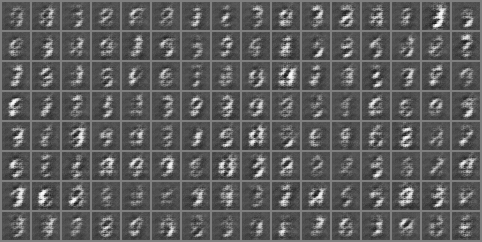

[1/5][200/468][25.4035 s]	Loss_D: -36.8715	Loss_G: 9.6536	Lip(D): 0.4196


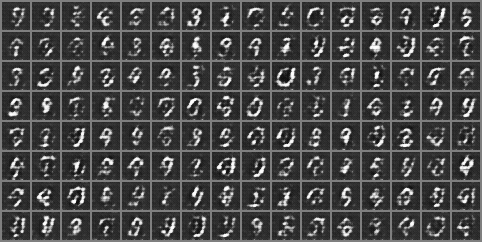

[1/5][300/468][38.2826 s]	Loss_D: -84.0654	Loss_G: 54.6823	Lip(D): 0.3861


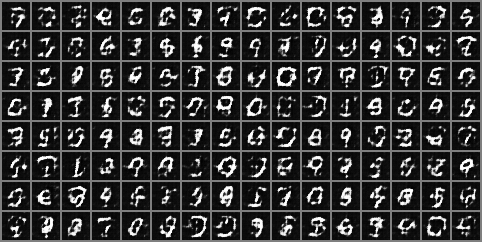

[1/5][400/468][51.0119 s]	Loss_D: -68.5132	Loss_G: 50.0467	Lip(D): 0.1385


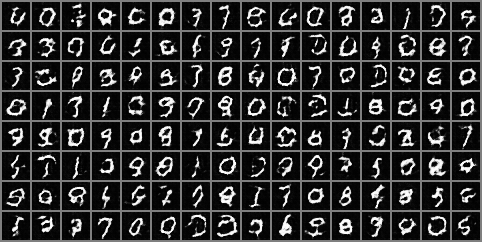

[2/5][0/468][59.8363 s]	Loss_D: -44.0068	Loss_G: 39.8727	Lip(D): 2.1912


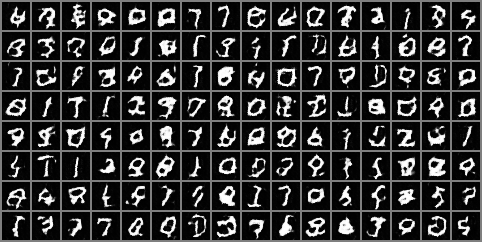

[2/5][100/468][72.8380 s]	Loss_D: -57.2097	Loss_G: 88.8528	Lip(D): 0.7415


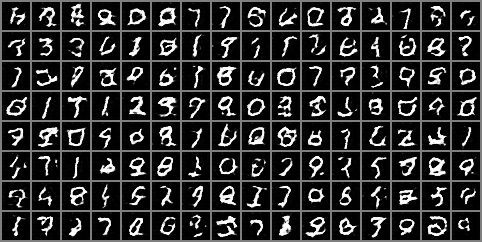

[2/5][200/468][86.0297 s]	Loss_D: -31.9302	Loss_G: 3.4758	Lip(D): 3.0504


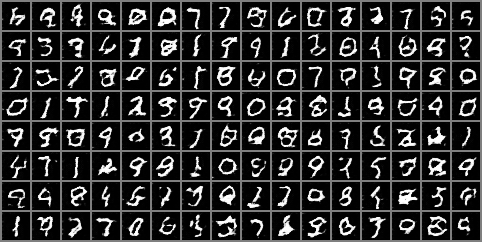

[2/5][300/468][99.3996 s]	Loss_D: -18.0169	Loss_G: 35.4291	Lip(D): 1.1258


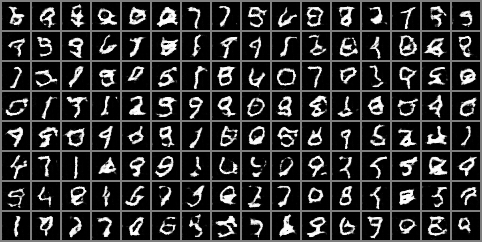

[2/5][400/468][112.6533 s]	Loss_D: -58.9024	Loss_G: 59.2347	Lip(D): 2.5445


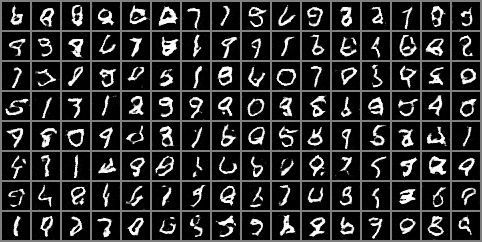

[3/5][0/468][121.6859 s]	Loss_D: -32.3861	Loss_G: 54.5980	Lip(D): 0.3972


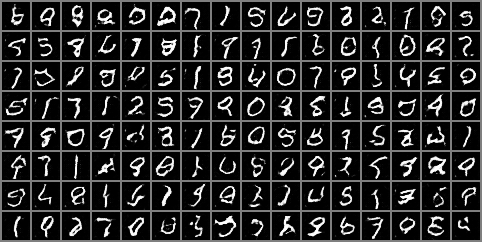

[3/5][100/468][134.9401 s]	Loss_D: -45.3070	Loss_G: 37.8776	Lip(D): 0.7515


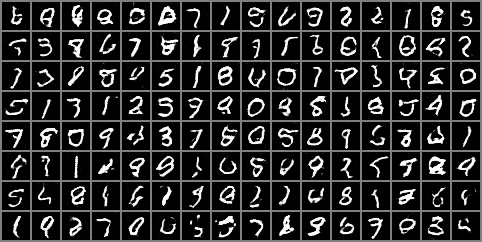

[3/5][200/468][148.0232 s]	Loss_D: -13.1650	Loss_G: -21.4715	Lip(D): 1.4353


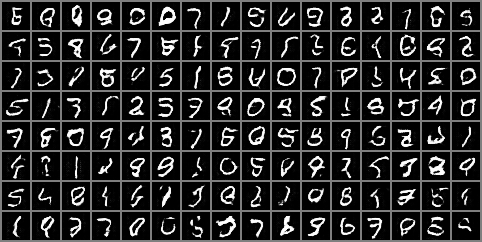

[3/5][300/468][161.1099 s]	Loss_D: -29.3448	Loss_G: 26.6093	Lip(D): 1.3808


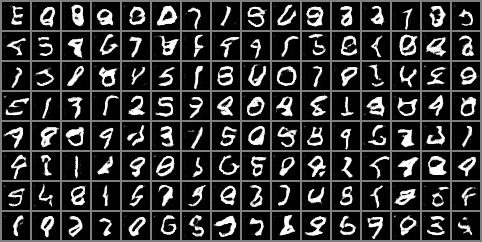

[3/5][400/468][174.2808 s]	Loss_D: -47.0356	Loss_G: 42.7073	Lip(D): 1.4635


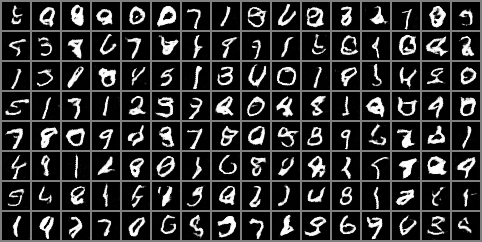

[4/5][0/468][183.4930 s]	Loss_D: -10.0618	Loss_G: 29.1975	Lip(D): 1.5188


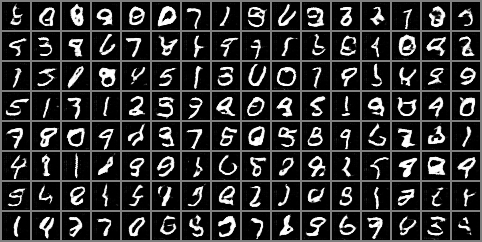

[4/5][100/468][196.6327 s]	Loss_D: -18.1515	Loss_G: 40.3151	Lip(D): 0.7492


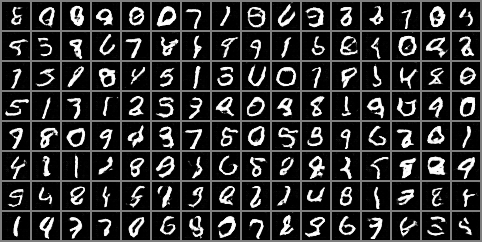

[4/5][200/468][209.7914 s]	Loss_D: -43.9940	Loss_G: 50.9238	Lip(D): 0.7380


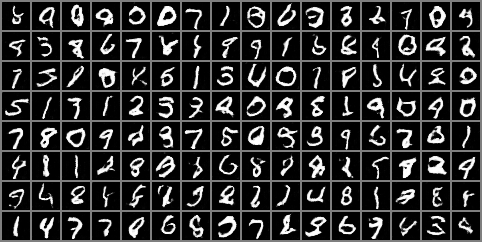

[4/5][300/468][222.9525 s]	Loss_D: -12.7720	Loss_G: 1.9903	Lip(D): 2.2942


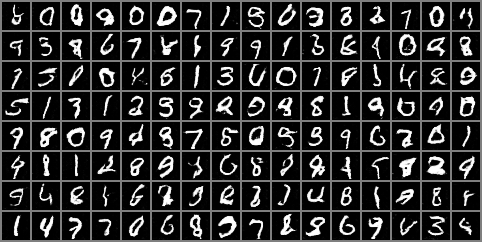

[4/5][400/468][236.1056 s]	Loss_D: -45.1278	Loss_G: 64.7881	Lip(D): 0.8933


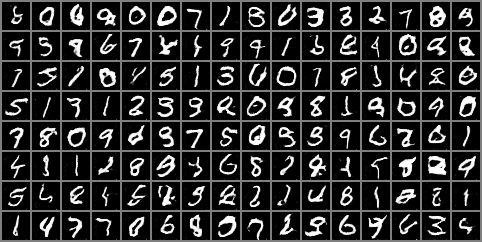

[5/5][0/468][245.1240 s]	Loss_D: 21.8784	Loss_G: 236.5664	Lip(D): 0.5960


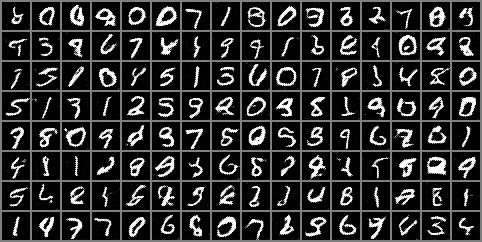

[5/5][100/468][258.2702 s]	Loss_D: -24.9629	Loss_G: 64.7010	Lip(D): 2.6718


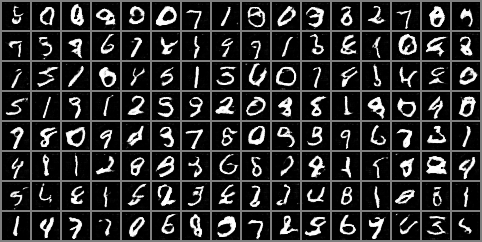

[5/5][200/468][271.5851 s]	Loss_D: -41.5819	Loss_G: 67.8630	Lip(D): 1.2236


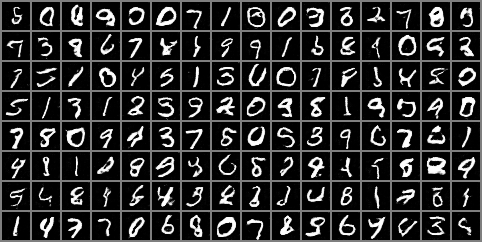

[5/5][300/468][285.1776 s]	Loss_D: -8.9015	Loss_G: 18.5035	Lip(D): 0.9442


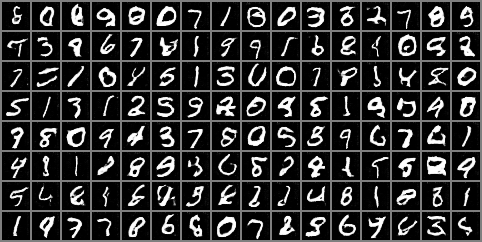

[5/5][400/468][298.3669 s]	Loss_D: -6.4674	Loss_G: -14.0470	Lip(D): 1.5428


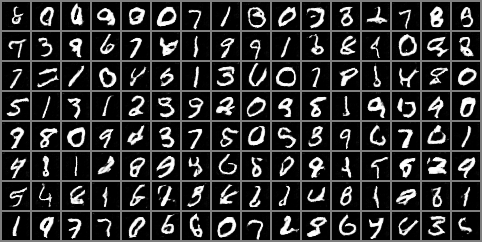

Total learning time =  307.2269666194916


<All keys matched successfully>

In [10]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

niterG = 10
niterD = 10
t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update D network
        ### ... ###

        optimD.zero_grad()

        D_real = D(real)
        D_fake = D(fake)
        GP =  gradient_penalty(D,real,fake)
        Dloss = -Loss_WGAN_GP(D_real,D_fake,GP,gpw)

        Dloss.backward()
        optimD.step()
        ############################

        # Update G network
        ### ... ###

        optimG.zero_grad()
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        D_fake = D(fake)
        Gloss = -D_fake.mean(axis=0)

        Gloss.backward()
        optimG.step()
          ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


In [11]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())


<All keys matched successfully>

<br/><br/><br/><br/><br/>

# Part 2 BONUS: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

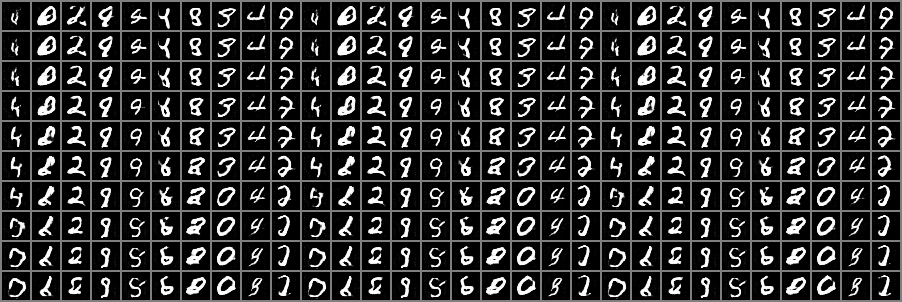

In [12]:
# You may load a trained generator from a file
# G = Generator().to(device)
# G.load_state_dict(torch.load('wgan_epoch100.pt'))
# G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10
nk = 30

z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

genimages = torch.zeros((minib*nk,1,28,28))
for k in np.arange(nk):
    alpha = k / (nk - 1)
    z_alpha = (1 - alpha) * z0 + alpha * z1
    genimages[k * minib: (k + 1) * minib] = G(z_alpha).detach()

pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset

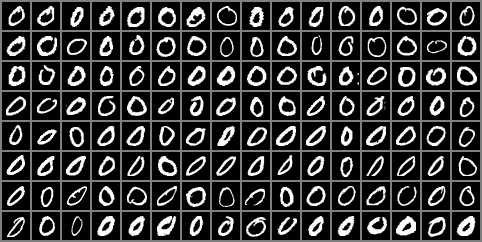

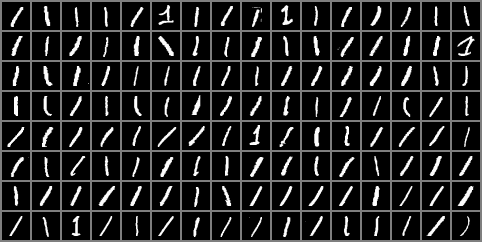

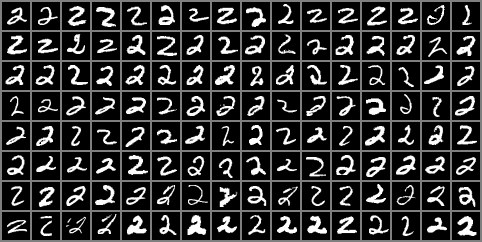

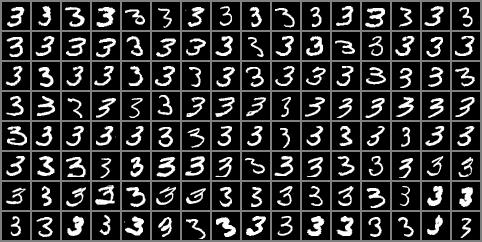

In [13]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

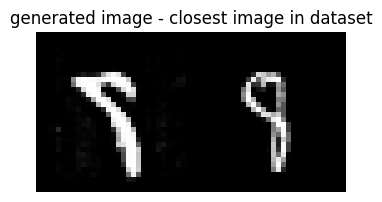

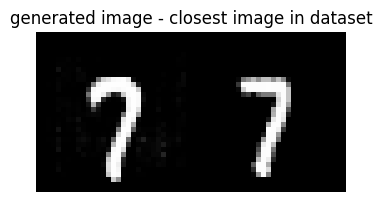

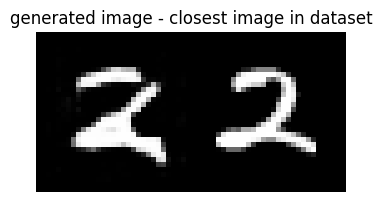

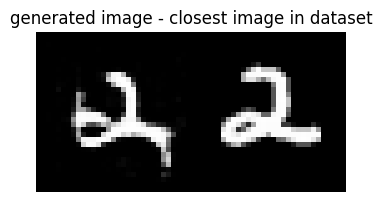

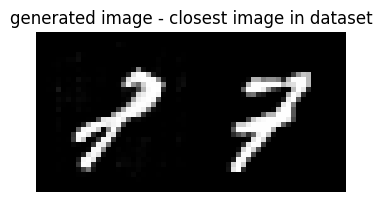

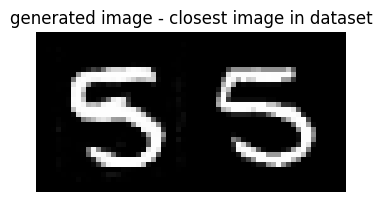

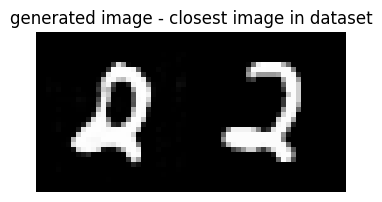

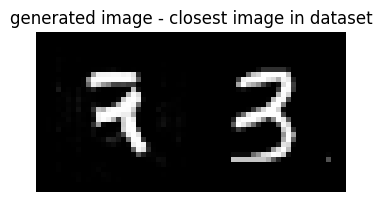

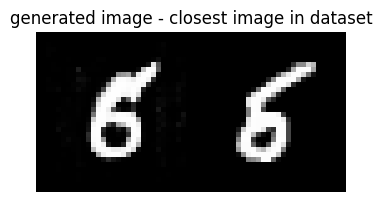

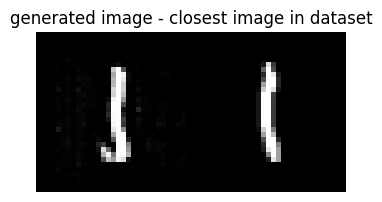

In [16]:
# Load all the dataset
train_loader_all = torch.utils.data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y, labels = next(iter(train_loader_all))

# Define function to display images side by side
def display_images(generated, nearest):
    combined = torch.cat([generated, nearest], dim=0)
    grid = torchvision.utils.make_grid(combined, nrow=2, padding=2, normalize=True)
    plt.figure(figsize=(4, 4))
    plt.title("generated image - closest image in dataset")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Generate samples from the generator
z = torch.randn(10, nz, 1, 1, device=device)
generated_samples = G(z).detach().cpu()

# Flatten the images for distance computation
generated_samples_flat = generated_samples.view(generated_samples.size(0), -1)
real_images_flat = y.view(y.size(0), -1)

# Compute the nearest neighbors
distances = torch.cdist(generated_samples_flat, real_images_flat)
nearest_indices = distances.argmin(dim=1)
nearest_neighbors = y[nearest_indices]

# Display the generated samples and their nearest neighbors side by side
for i in range(generated_samples.size(0)):
    display_images(generated_samples[i].unsqueeze(0), nearest_neighbors[i].unsqueeze(0))
